In [2]:
import sys
import random
import numpy as np
import pdb
import math
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
#actions
_stay = 0
_left = 1
_right = 2


# other global parameters

episode=10000
end_timestep=5
gamma=1
alpha=0.1
alpha_decay=0.9999
epsilon=0.05
epsilon_decay=0.9999
num_agents=100
capacity=7


x_axis=np.arange(0,episode,1)

In [3]:
class BeachAgent(object):
    def __init__(self, agent_id, start_pos, alpha, alpha_decay, epsilon, epsilon_decay, gamma):
        self.agent_id=agent_id
        self.last_action = 0
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.alpha=alpha
        self.alpha_decay=alpha_decay
        self.gamma=gamma
        self.position=start_pos
        self.last_position=start_pos
        self.qtable=[]
        self.potential=np.zeros(5, dtype=float)
        self.encouraged_state=0
        self._init_qtable(5, 3)
        self._init_potential(1)
        self.previous_potential=0
        self.current_potential=0
    
        
    
        
        
    def _init_qtable(self,section_num, action_num):
        '''
            Initialize qtable to -1
            each section has 3 actions
            0 : stay
            1 : left
            2 : right

        '''
        self.qtable = [[-1 for i in range(action_num)] for k in range(section_num)]
        
        
    def restart(self):
        if self.agent_id<50:
            self.position=1
        else:
            self.position=3
        self.last_action = 0
        self.last_position=self.position
        self.previous_potential=0
        self.current_potential=0
        
        
        
        
    def _init_potential(self, heuristic):
        if heuristic==1: # first heuristic
            if self.agent_id>=0 and self.agent_id<=capacity-1:
                self.potential[0]=10
                self.encouraged_state=0
            elif self.agent_id>=capacity and self.agent_id<=2*capacity-1:
                self.potential[1]=10
                self.encouraged_state=1
            elif self.agent_id>=2*capacity and self.agent_id<=100-2*capacity-1:
                self.potential[2]=10
                self.encouraged_state=2
            elif self.agent_id>=100-2*capacity and self.agent_id<=100-capacity-1:
                self.potential[3]=10
                self.encouraged_state=3
            elif self.agent_id>=100-capacity and self.agent_id<=100-1:
                self.potential[4]=10
                self.encouraged_state=4
        
        
        
    def select_action(self):
        """
        Select an action using epsilon-greedy algorithm, and filter out illegal actions
        """
        self.last_position=self.position
        self._update_parameters()
        action = self._e_greedy()

        self.last_action = action 
        #if self.position==0 and action==_left:
        #    self.last_action=0
        #if self.position==4 and action==_right:
        #    self.last_action=0
        return action
    
    def do_action(self):
        """
        Move agents to new position/state
        """
        
        
        if self.last_action==_left and self.position>0:
            self.position-=1
        elif self.last_action==_right and self.position<4:
            self.position+=1      
        
    
    def _e_greedy(self):
        """
        Epsilon-greedy algorithm
        """
        if random.random() <= self.epsilon:
            action = self.random_select_action()
        else:
            action = self.greedy_select_action()

        return action
    
    def greedy_select_action(self):
        """
        Select max q-value. First get the max value and get the action. If there are 2 or 3 max values, just randomly choose one
        """
        
        max_reward=max(self.qtable[self.position])
        max_index=[i for i,x in enumerate(self.qtable[self.position]) if x==max_reward] 
        if len(max_index)>1:
            max_action=random.choice(max_index)
        else:
            max_action=max_index[0]

        return max_action 

    def random_select_action(self):
        """
        Select action randomly
        """
        action = random.randint(0,2)
                
        return action

    def _update_q_table(self, reward):
        """
        Update q-table
        """
        
        self.qtable[self.last_position][self.last_action] = self.alpha * reward + (1.0 - self.alpha)*self.qtable[self.last_position][self.last_action]+self.alpha*self.gamma*max(self.qtable[self.position])
        #self.qtable[self.last_position][self.last_action] = round(self.qtable[self.last_position][self.last_action], 3)
    
    def _update_final_qtable(self, reward):
        """
        Update final q table
        """
        
        self.qtable[self.position][self.last_action] = self.alpha * reward + (1.0 - self.alpha)*self.qtable[self.position][self.last_action]
        #self.qtable[self.position][self.last_action] = round(self.qtable[self.position][self.last_action], 3)
    def _update_parameters(self):
        """
        Update epsilon and alpha (learning rate)
        """
        self.epsilon=self.epsilon*self.epsilon_decay
        self.alpha=self.alpha*self.alpha_decay


In [4]:
class BeachProblemDomain:
    agents = []
    def __init__(self):
        self._init_agents()
        self.local_rewards=np.zeros(5, dtype=float)
        self.other_local_rewards=np.zeros(5, dtype=float)
        self.no_agents=np.zeros(5, dtype=int)
        self.global_rewards=0
  

    def _init_agents(self):
        """ initialize agents
            all agent select action by epsilon greedy .
        """
        self.agents = [BeachAgent(agent_id=i, start_pos=1, alpha=alpha, alpha_decay=alpha_decay, epsilon=epsilon, epsilon_decay=epsilon_decay, gamma=gamma) for i in range(0, 50)]
        self.agents += [BeachAgent(agent_id=i, start_pos=3, alpha=alpha, alpha_decay=alpha_decay, epsilon=epsilon, epsilon_decay=epsilon_decay, gamma=gamma) for i in range(50, 100)] 
        
        
    def cal_local_rewards(self):
        """
        Calculate local rewards
        """
        self.no_agents=np.zeros(5, dtype=int)
        self.local_rewards=np.zeros(5, dtype=float)
        self.other_local_rewards=np.zeros(5, dtype=float)
        self.global_rewards=0
        
        for i in range(100):
            k=self.agents[i].position
            self.no_agents[k]+=1
            
        for j in range(5):
            
            self.local_rewards[j]=self.no_agents[j]*math.exp(-self.no_agents[j]/capacity)
            self.other_local_rewards[j]=(self.no_agents[j]-1)*math.exp((-self.no_agents[j]+1)/capacity)
            
        self.global_rewards=sum(self.local_rewards)    
            
            
            
            
        
        
        

In [5]:
#
def local_reward_simulation():
    """
    Local rewards alone
    """
    bpd=BeachProblemDomain()
    global_reward_list=[]
    for e in range(episode):
        for t in range(end_timestep):
            for agent in bpd.agents:
                action=agent.select_action()
                agent.do_action()
            
            bpd.cal_local_rewards()
                
            for agent in bpd.agents:
                position=agent.position
                agent._update_q_table(bpd.local_rewards[position])
                
                
        for agent in bpd.agents:
            action=agent.select_action()
            agent._update_final_qtable(0)
            agent.restart()
            #agent.previous_potential=0
            #agent.current_potential=0
                
                
        global_reward_list.append(bpd.global_rewards)
    
    return global_reward_list


def global_reward_simulation():
    """
    Global rewards alone
    """
    
    bpd2=BeachProblemDomain()
    global_reward_list2=[]
    for e in range(episode):
        for t in range(end_timestep):
            for agent in bpd2.agents:
                action=agent.select_action()
                agent.do_action()
            
            bpd2.cal_local_rewards()
            #global_reward=sum(bpd2.local_rewards)
            for agent in bpd2.agents:
                #position=agent.position
                agent._update_q_table(bpd2.global_rewards)
                #agent._update_parameters()
                
        for agent in bpd2.agents:
            action=agent.select_action()
            agent._update_final_qtable(0)
            agent.restart()
            
                
        global_reward_list2.append(bpd2.global_rewards)
    
    
    return global_reward_list2

def difference_reward_simulation():
    """
    Difference rewards alone
    """
    
    bpd3=BeachProblemDomain()
    global_reward_list3=[]
    for e in range(episode):
        for t in range(end_timestep):
            for agent in bpd3.agents:
                action=agent.select_action()
                agent.do_action()
            
            bpd3.cal_local_rewards()
            
            for agent in bpd3.agents:
                position=agent.position
                agent._update_q_table(bpd3.local_rewards[position]-bpd3.other_local_rewards[position])
                #agent._update_parameters()
                
        for agent in bpd3.agents:
            action=agent.select_action()
            agent._update_final_qtable(0)
            agent.restart() 
            
        global_reward_list3.append(bpd3.global_rewards)
    
    return global_reward_list3
        
def manual_pbrs_simulation():
    """
    G+ManualPBRS simulation
    """
    bpd4=BeachProblemDomain()
    global_reward_list4=[]
    
    
    for e in range(episode):
        
        for t in range(end_timestep):
            for agent in bpd4.agents:
                
                action=agent.select_action()
                agent.do_action()          
            
            bpd4.cal_local_rewards()
            
            for agent in bpd4.agents:
                position=agent.position
                last_position=agent.last_position
                if position==agent.encouraged_state:
                    agent.current_potential=10
                else:
                    agent.current_potential=0
                if last_position==agent.encouraged_state:
                    agent.previous_potential=10
                else:
                    agent.previous_potential=0
                shaped_r=bpd4.global_rewards+agent.gamma*agent.current_potential-agent.previous_potential
                agent._update_q_table(shaped_r)
                agent.previous_potential=agent.current_potential
                
        for agent in bpd4.agents:
            
            action=agent.select_action()
            shaped_r=0-agent.current_potential
            agent._update_final_qtable(shaped_r)
            agent.restart()
            
            
                
        #bpd4.cal_local_rewards()        
        global_reward_list4.append(bpd4.global_rewards)
    
    return global_reward_list4


def drip_simulation():
    """
    DRiP simulation
    """
    bpd5=BeachProblemDomain()
    global_reward_list5=[]
    
    for e in range(episode):
        for t in range(end_timestep):
            for agent in bpd5.agents:
                    
                action=agent.select_action()
                agent.do_action()      
            
            bpd5.cal_local_rewards()
            
            for agent in bpd5.agents:
                position=agent.position
                last_position=agent.last_position
                dr=bpd5.local_rewards[position]-bpd5.other_local_rewards[position]
                shaped_r=dr+agent.gamma*agent.potential[position]-agent.potential[last_position]
                
                agent._update_q_table(shaped_r)
                
                
                
        for agent in bpd5.agents:
            
            action=agent.select_action()
            shaped_r=0-agent.potential[position]
            agent._update_final_qtable(shaped_r)
            agent.restart()
            
                
        #bpd5.cal_local_rewards()        
        global_reward_list5.append(bpd5.global_rewards)
    
    
    return global_reward_list5


def cap_simulation():
    """
    CaP simulation
    """
    bpd6=BeachProblemDomain()
    global_reward_list6=[]
    
    for e in range(episode):
        for t in range(end_timestep):
            for agent in bpd6.agents:
                    
                action=agent.select_action()
                agent.do_action()      
            
            bpd6.cal_local_rewards()
            
            for agent in bpd6.agents:
                position=agent.position
                last_position=agent.last_position
                dr=bpd6.local_rewards[position]-bpd6.other_local_rewards[position]
                agent.current_potential=bpd6.global_rewards-dr
                shaped_r=bpd6.global_rewards+agent.gamma*agent.current_potential-agent.previous_potential
                
                agent._update_q_table(shaped_r)
                agent.previous_potential=agent.current_potential
                
        for agent in bpd6.agents:
            
            action=agent.select_action()
            shaped_r=0-agent.current_potential
            agent._update_final_qtable(shaped_r)
            #agent.position=agent.encouraged_state
            agent.restart()
                
         
        global_reward_list6.append(bpd6.global_rewards)
    
    
    return global_reward_list6



In [6]:
list1=[]
list2=[]
list3=[]
list4=[]
list5=[]
list6=[]
for i in range(30):  #run simulation 10 times and get average
    print(i)
   
    local_array=np.array(local_reward_simulation())
    global_array=np.array(global_reward_simulation())
    difference_array=np.array(difference_reward_simulation())
    manual_array=np.array(manual_pbrs_simulation())
    
    drip_array=np.array(drip_simulation())
    cap_array=np.array(cap_simulation())
    
    list1.append(local_array)
    list2.append(global_array)
    list3.append(difference_array)
    list4.append(manual_array)
   
    list5.append(drip_array)
    list6.append(cap_array)

list1=np.array(list1)
list2=np.array(list2)
list3=np.array(list3)
list4=np.array(list4)

list5=np.array(list5)
list6=np.array(list6)

list1=np.average(list1, axis=0)
list2=np.average(list2, axis=0)
list3=np.average(list3, axis=0)
list4=np.average(list4, axis=0)

list5=np.average(list5, axis=0)
list6=np.average(list6, axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


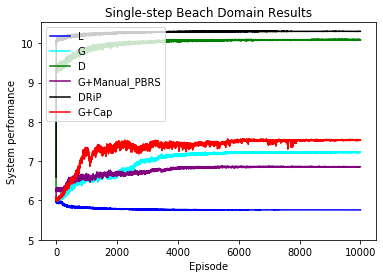

In [7]:

plt.plot(x_axis,list1,color="blue", label="L")
plt.plot(x_axis,list2,color="cyan", label="G")
plt.plot(x_axis,list3, color="green",label="D")
plt.plot(x_axis,list4, color="purple", label="G+Manual_PBRS")
plt.plot(x_axis,list5, color="black", label="DRiP")
plt.plot(x_axis,list6, color="red",label="G+Cap")
plt.legend()
plt.ylim(ymin=5)
plt.xlabel('Episode')
plt.ylabel('System performance')
plt.title('Single-step Beach Domain Results')
plt.savefig('Figure_4.png')
plt.show()



[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]
